In [1]:
import artm
import json
from collections import Counter

## Подготавливаем данные в формате vw

In [11]:
def get_words_freq(lines):
    counter_title = Counter()
    counter_text = Counter()
    common_counter = Counter()
    for line in lines:
        doc = json.loads(line)
        for word in doc['text'].split(" "):
            counter_text[word] += 1
            common_counter[word] += 1
        for word in doc['title'].split(" "):
            counter_title[word] += 1
            common_counter[word] += 1
    return counter_text, counter_title, common_counter

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
def prepare_data(input_file, output_train_file, output_validation_file):
    documents = []
    labels = []
    file = open(input_file)
    lines = file.read()
    file.close()
    lines = lines.split("\n")
    lines = lines[:-1]
    counter_text, counter_title, common_counter = get_words_freq(lines)
    for i, line in enumerate(lines):
        doc = json.loads(line)
        documents.append(doc['text'])
        labels.append(doc['label'])
    train_docs, validation_docs, train_labels, validation_labels = train_test_split(
        documents, labels,test_size=0.3, random_state=42, stratify=labels)
    file = open(output_train_file, "w")
    for i, document in enumerate(train_docs):
        st = "doc" + str(i) + " |@default_class "
        st += document
        st += " |@label "
        st += str(train_labels[i])
        file.write(st + "\n")
    file.close()
    file = open(output_validation_file, "w")
    for i, document in enumerate(validation_docs):
        st = "doc" + str(i) + " |@default_class "
        st += document
        st += " |@label "
        st += str(validation_labels[i])
        file.write(st + "\n")
    file.close()
    return train_docs, validation_docs, train_labels, validation_labels

In [14]:
train_docs, validation_docs, train_labels, validation_labels = prepare_data(
    'data/train', 'data/prepared_train.wv', 'data/prepared_validation.wv')

In [6]:
len(train_docs)

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


392000

In [7]:
len(validation_docs)

168000

## Делаем батчи

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
batch_vectorizer = artm.BatchVectorizer(data_path='data/prepared_train.wv',
                                        data_format='vowpal_wabbit',
                                        target_folder='artm_batches_train')

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
validation_batch_vectorizer = artm.BatchVectorizer(data_path='data/prepared_validation.wv',
                                        data_format='vowpal_wabbit',
                                        target_folder='artm_batches_validation')

In [3]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='artm_batches_train')

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
dictionary

artm.Dictionary(name=fdb2b7c1-5113-4ec9-8d22-551c1b053e9b, num_entries=516743)

In [5]:
dictionary.filter(min_df=2)

artm.Dictionary(name=fdb2b7c1-5113-4ec9-8d22-551c1b053e9b, num_entries=182619)

In [31]:
def create_plsa_model(num_topics, num_iters, batch_vectorizer):
    model = artm.ARTM(num_topics=num_topics, num_document_passes=5,cache_theta=True,
                      scores=[
                    artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                    artm.SparsityPhiScore(name='SparsityPhiScore'),
                    artm.SparsityThetaScore(name='SparsityThetaScore'),
                    artm.scores.TopTokensScore(name='TopTokensScore', dictionary=dictionary, num_tokens=20),
                    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3)])
    model.initialize(dictionary)
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_iters)
    return model


In [37]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
classifiers = [LogisticRegression(C=100, random_state=42, n_jobs=8, max_iter=10, multi_class='multinomial'),
               KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', n_jobs=8),
               RandomForestClassifier(n_estimators=20, n_jobs=8, random_state=42),
               GradientBoostingClassifier(n_estimators=20, subsample=1.0, max_depth=4, random_state=42)
              ]

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
from sklearn.metrics import f1_score, accuracy_score
def get_scores(model, train_labels, validation_batch_vectoriser, validation_labels, classifiers):
    train_theta = model.get_theta()
    train_theta = train_theta.reindex(sorted(train_theta.columns), axis=1)
    validation_theta = model.transform(validation_batch_vectoriser)
    validation_theta = validation_theta.reindex(sorted(validation_theta.columns), axis=1)
    print("build modle and thetas")
    accuracy = []
    f1_micro = []
    f1_macro = []
    for clf in classifiers:
        clf.fit(train_theta.values.T, train_labels)
        predictions = clf.predict(validation_theta.values.T)
        accuracy.append(accuracy_score(predictions, validation_labels))
        f1_micro.append(f1_score(predictions, validation_labels, average='micro'))
        f1_macro.append(f1_score(predictions, validation_labels, average='macro'))
        print('Accuracy: {}, F1(micro): {}, F1(macro): {}'.format(
        accuracy_score(predictions, validation_labels), 
        f1_score(predictions, validation_labels, average='micro'), 
        f1_score(predictions, validation_labels, average='macro')))
    return np.array(accuracy).mean(), np.array(f1_micro).mean(), np.array(f1_macro).mean()

In [ ]:
phi_sparsifier_tau_list = np.array([-5e-2, -0.025, -1e-2, -1e-3, -1e-4, 0])
best_model.regularizers.add(artm.SmoothSparsePhiRegularizer(
    name='PhiSmoother', tau=0.0, dictionary=dictionary))

In [7]:
from sklearn.cluster import KMeans

/home/anirogozina/artm/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  collections.MutableMapping.register(ParseResults)


## Модель с 20 темами

In [10]:
model = create_plsa_model(num_topics=20, num_iters=70)

In [11]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(
    name='PhiSmoother', tau=1e-4, dictionary=dictionary))

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
model.save("plsa_phi_first")

In [13]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

In [14]:
model.score_tracker

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'PerplexityScore': <artm.score_tracker.PerplexityScoreTracker at 0x7f4358a57400>,
 'SparsityPhiScore': <artm.score_tracker.SparsityPhiScoreTracker at 0x7f4358a57160>,
 'SparsityThetaScore': <artm.score_tracker.SparsityThetaScoreTracker at 0x7f4358a573c8>,
 'TopTokensScore': <artm.score_tracker.TopTokensScoreTracker at 0x7f4358a57668>,
 'TopicKernelScore': <artm.score_tracker.TopicKernelScoreTracker at 0x7f4358a576a0>}

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


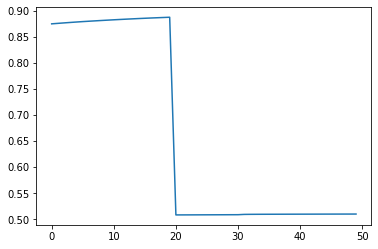

In [17]:
plt.plot(model.score_tracker['SparsityPhiScore'].value[50:])

In [18]:
model.save("plsa_phi_first")

In [9]:
from sklearn.cluster import KMeans

/home/anirogozina/artm/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  collections.MutableMapping.register(ParseResults)


In [20]:
phi = model.get_phi()

In [21]:
phi

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
caddick,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.378758e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.860630e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
zunil,0.000000e+00,0.000000e+00,1.965728e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.089062e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
lindland,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.757342e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
hailan,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.358587e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.372664e-06,0.000000e+00,0.000000e+00,1.837891e-06,0.000000e+00
oddlooking,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.745672e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
schiffbaugesellschaft,2.866260e-16,1.515625e-16,1.983768e-16,2.185107e-16,2.891938e-16,2.299450e-16,2.942365e-16,2.218936e-16,1.820023e-16,3.319306e-16,1.956838e-16,3.595368e-16,3.389513e-16,3.591306e-16,1.861563e-16,1.669970e-16,3.381456e-16,2.502217e-16,2.228896e-16,2.653665e-05
riegert,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.306698e-16,0.000000e+00,1.161208e-16,1.042892e-16,1.092233e-16,0.000000e+00,0.000000e+00,1.063384e-16,0.000000e+00,7.350645e-06,0.000000e+00
chiaki,2.480981e-16,1.167174e-16,1.520188e-16,1.681564e-16,4.521512e-16,1.622979e-16,2.269274e-16,1.769442e-16,1.425668e-16,2.553940e-16,2.015362e-16,2.670976e-16,2.607231e-16,2.702327e-16,1.424184e-16,1.281478e-16,2.615364e-16,5.030394e-16,1.837661e-05,1.905194e-16
coauthor,3.359883e-15,1.995747e-15,2.086241e-15,4.817836e-15,3.648312e-15,2.547986e-15,3.118443e-15,6.654484e-15,2.001289e-15,9.475190e-15,2.125723e-04,4.183263e-15,3.639770e-15,4.062841e-15,2.193691e-15,1.722102e-15,3.504532e-15,8.167367e-15,2.809048e-15,2.725637e-15


In [6]:
model = artm.ARTM(num_topics=20, num_document_passes=5,cache_theta=True,
                      scores=[
                    artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                    artm.SparsityPhiScore(name='SparsityPhiScore'),
                    artm.SparsityThetaScore(name='SparsityThetaScore'),
                    artm.scores.TopTokensScore(name='TopTokensScore', dictionary=dictionary, num_tokens=20),
                    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3)])
model.load('plsa_phi_first')

In [7]:
phi = model.get_phi()

# K-means

In [16]:
num_clusters = [3000, 500, 1000, 1500, 2000, 3000]
DEFAULT_TOKEN = 'DEFAULT'
for num in num_clusters:
    clustering = KMeans(n_clusters=num, random_state=42)
    clustering.fit(phi)
    print('create clusters')
    predictions = clustering.predict(phi)
    phi['index' + str(num_clusters)] = predictions
    print('create predictions')
    file = open('validation_k_means' +str(num), "w")
    for i, document in enumerate(validation_docs):
        st = "doc" + str(i) + " |@default_class "
        for word in document.split(" "):
            if word in phi.index:
                st += str(int(phi.loc[word]['index' + str(num_clusters)]))
            else:
                st += DEFAULT_TOKEN
            st += ' '
        st += " |@label "
        st += str(validation_labels[i])
        file.write(st + "\n")
    file.close()
    print('finished validation')
    file = open('train_k_means' +str(num), "w")
    for i, document in enumerate(train_docs):
        st = "doc" + str(i) + " |@default_class "
        for word in document.split(" "):
            if word in phi.index:
                st += str(int(phi.loc[word]['index' + str(num_clusters)]))
            else:
                st += DEFAULT_TOKEN
            st += ' '
        st += " |@label "
        st += str(validation_labels[i])
        file.write(st + "\n")
    file.close()
    

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


create clusters
create predictions
finished validation


NameError: name 'train' is not defined

In [21]:
file = open('train_k_means' +str(num), "w")
for i, document in enumerate(train_docs):
    st = "doc" + str(i) + " |@default_class "
    for word in document.split(" "):
        if word in phi.index:
            st += str(int(phi.loc[word]['index' + str(num_clusters)]))
        else:
            st += DEFAULT_TOKEN
        st += ' '
    st += " |@label "
    st += str(train_labels[i])
    file.write(st + "\n")
file.close()

In [27]:
new_model_batch_vectorizer = artm.BatchVectorizer(data_path='train_k_means3000',
                                        data_format='vowpal_wabbit',
                                        target_folder='artm_batches_train_new')

In [30]:
new_model_validation_batch_vectoriser = artm.BatchVectorizer(data_path='validation_k_means3000',
                                        data_format='vowpal_wabbit',
                                        target_folder='artm_batches_validation_new')

In [28]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='artm_batches_train_new')

In [29]:
dictionary

artm.Dictionary(name=ec1fb4c3-119e-4261-95c4-cf1b95d5c55c, num_entries=3001)

In [47]:
import numpy as np

In [49]:
model = create_plsa_model(20, 50, new_model_batch_vectorizer)
model.regularizers.add(artm.SmoothSparsePhiRegularizer(
    name='PhiSmoother', tau=1e-4, dictionary=dictionary))
model.fit_offline(batch_vectorizer=new_model_batch_vectorizer, num_collection_passes=30)
accuracy, f1_micro, f1_macro = get_scores(
    model, train_labels, new_model_validation_batch_vectoriser, validation_labels, classifiers)
print("num_topics", num_topics, "accuracy", accuracy, "f1_micro", f1_micro, "f1_macro", f1_macro)

/home/anirogozina/artm/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


build modle and thetas
Accuracy: 0.8609464285714286, F1(micro): 0.8609464285714286, F1(macro): 0.8596730472513135
Accuracy: 0.9022797619047619, F1(micro): 0.9022797619047619, F1(macro): 0.9022476366423892
Accuracy: 0.9274702380952381, F1(micro): 0.9274702380952381, F1(macro): 0.9274978579123647
Accuracy: 0.9081011904761904, F1(micro): 0.9081011904761904, F1(macro): 0.9080313831350226
num_topics 10 accuracy 0.8996994047619047 f1_micro 0.8996994047619047 f1_macro 0.8993624812352725


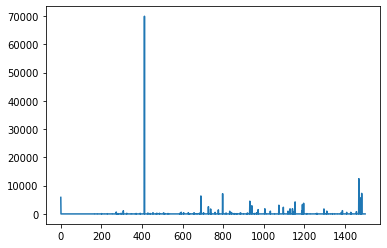

In [80]:
plt.plot(phi.groupby('index').count()['topic_0'])